# Tool choice

The Claude API supports a parameter called `tool_choice` that allows you to specify how you want Claude to call tools. In this notebook, we'll take a look at how it works and when to use it.

When working with the `tool_choice` parameter, we have three possible options: 

* `auto` allows Claude to decide whether to call any provided tools or not.
* `any` tells Claude that it must use one of the provided tools, but doesn't force a particular tool.
* `tool` allows us to force Claude to always use a particular tool.


This diagram illustrates how each option works: 

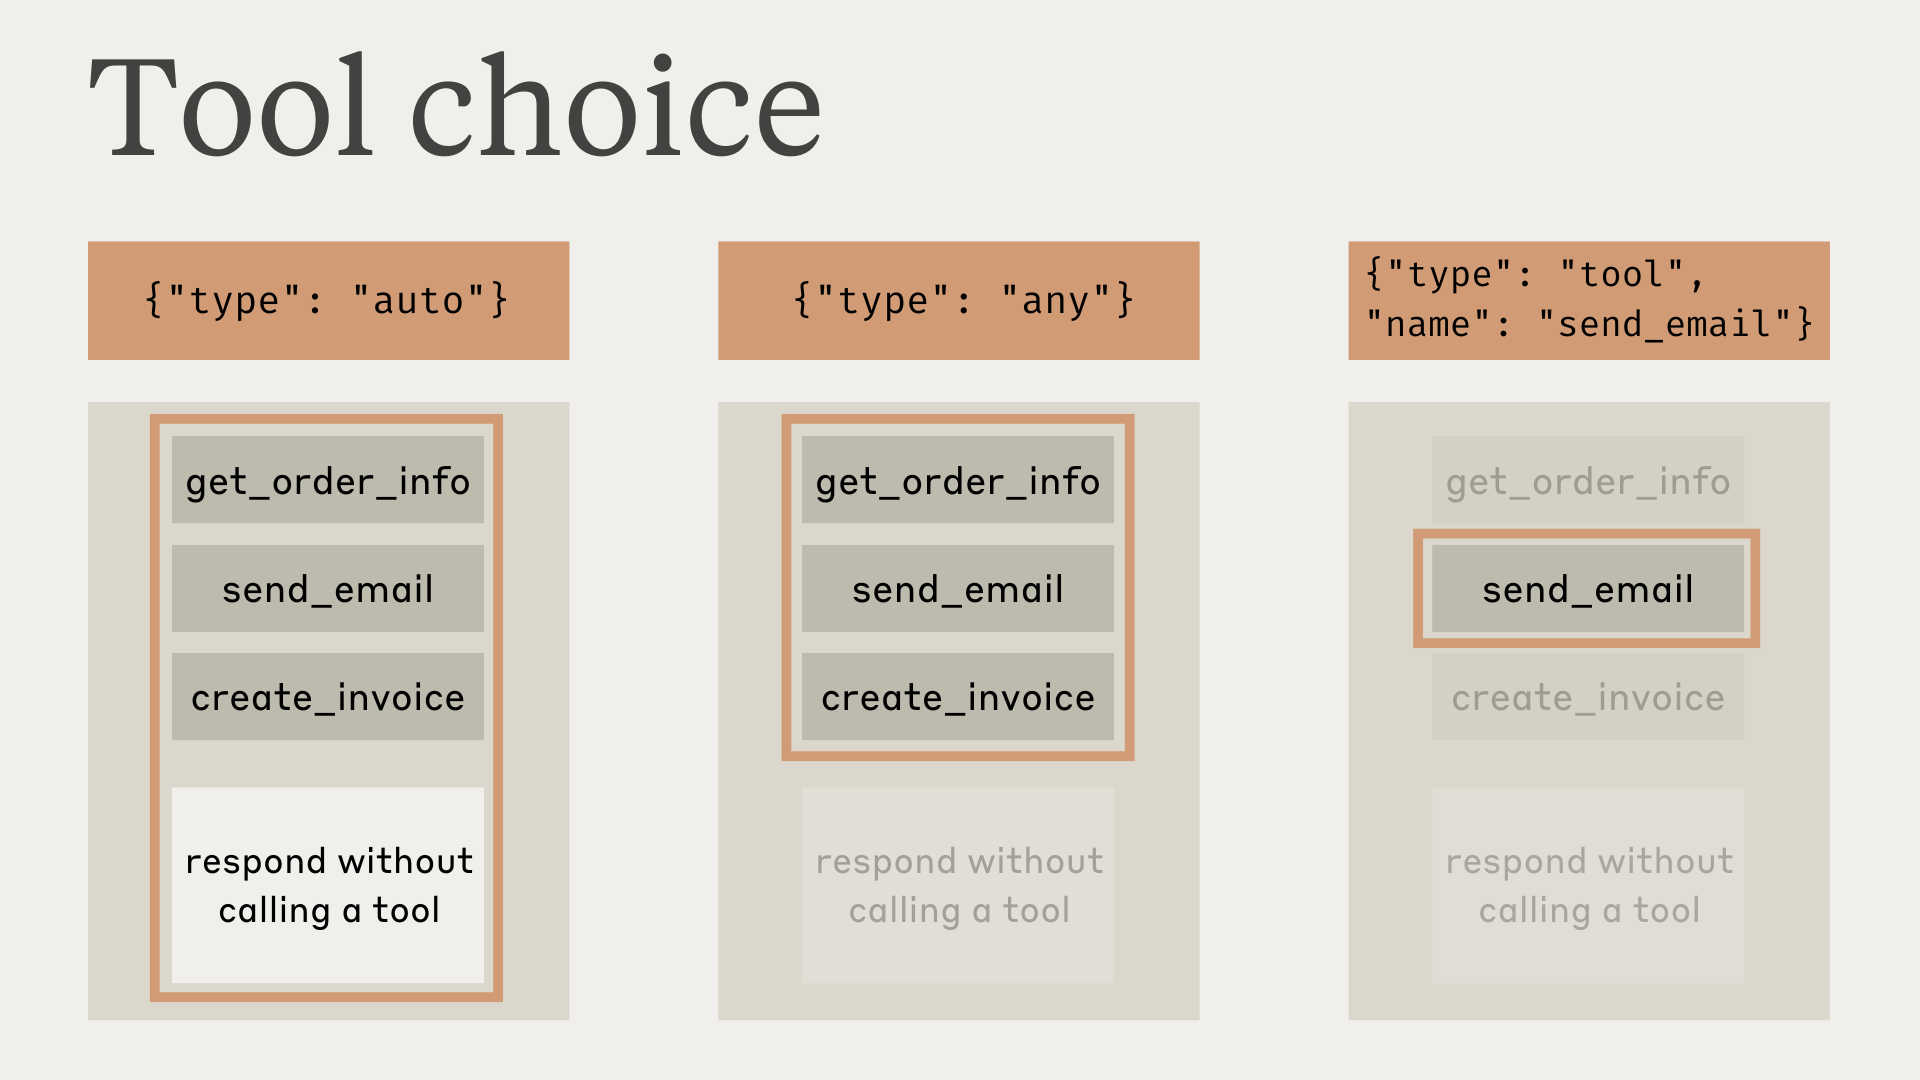

Let's take a look at each option in detail. We'll start by importing the Anthropic SDK:

In [31]:
from anthropic import Anthropic
client = Anthropic()

## Auto

Setting `tool_choice` to `auto` allows the model to automatically decide whether to use tools or not.  This is the default behavior when working with tools if you don't use the `tool_choice` parameter at all.

To demonstrate this, we're going to provide Claude with a fake web search tool. We will ask Claude questions, some of which would require calling the web search tool and others which Claude should be able to answer on its own.

Let's start by defining a tool called `web_search`.  Please note, to keep this demo simple, we're not actually searching the web here.

In [137]:
def web_search(topic):
    print(f"pretending to search the web for {topic}")

web_search_tool = {
    "name": "web_search",
    "description": "A tool to retrieve up to date information on a given topic by searching the web",
    "input_schema": {
        "type": "object",
        "properties": {
            "topic": {
                "type": "string",
                "description": "The topic to search the web for"
            },
        },
        "required": ["topic"]
    }
}


Next, we write a function that accepts a `user_query` and passes it along to Claude, along with the `web_search_tool`. 

We also set `tool_choice` to `auto`:

In [ ]:
tool_choice={"type": "auto"}

Here's the complete function:

In [145]:
from datetime import date

def chat_with_web_search(user_query):
    messages = [{"role": "user", "content": user_query}]

    system_prompt=f"""
    Answer as many questions as you can using your existing knowledge.  
    Only search the web for queries that you can not confidently answer.
    Today's date is {date.today().strftime("%B %d %Y")}
    If you think a user's question involves something in the future that hasn't happened yet, use the search tool.
    """

    response = client.messages.create(
        system=system_prompt,
        model="claude-3-sonnet-20240229",
        messages=messages,
        max_tokens=1000,
        tool_choice={"type": "auto"},
        tools=[web_search_tool]
    )
    last_content_block = response.content[-1]
    if last_content_block.type == "text":
        print("Claude did NOT call a tool")
        print(f"Assistant: {last_content_block.text}")
    elif last_content_block.type == "tool_use":
        print("Claude wants to use a tool")
        print(last_content_block)

Let's start with a question Claude should be able to answer without using the tool:

In [139]:
chat_with_web_search("What color is the sky?")

Claude did NOT call a tool
Assistant: The sky appears blue during the day. This is because the Earth's atmosphere scatters more blue light from the sun than other colors, making the sky look blue.


When we ask "What color is the sky?", Claude does not use the tool.  Let's try asking something that Claude should use the web search tool to answer:

In [140]:
chat_with_web_search("Who won the 2024 Miami Grand Prix?")

Claude wants to use a tool
ToolUseBlock(id='toolu_staging_018nwaaRebX33pHqoZZXDaSw', input={'topic': '2024 Miami Grand Prix winner'}, name='web_search', type='tool_use')


When we ask "Who won the 2024 Miami Grand Prix?", Claude uses the web search tool! 

Let's try a few more examples:

In [141]:
# Claude should NOT need to use the tool for this:
chat_with_web_search("Who won the Superbowl in 2022?")

Claude did NOT call a tool
Assistant: The Los Angeles Rams won Super Bowl LVI in 2022, defeating the Cincinnati Bengals by a score of 23-20. The game was played on February 13, 2022 at SoFi Stadium in Inglewood, California.


In [144]:
# Claude SHOULD use the tool for this:
chat_with_web_search("Who won the Superbowl in 2024?")

Claude wants to use a tool
ToolUseBlock(id='toolu_staging_016XPwcprHAgYJBtN7A3jLhb', input={'topic': '2024 Super Bowl winner'}, name='web_search', type='tool_use')


### Your prompt matters!

When working with `tool_choice` set to `auto`, it's important that you spend time to write a detailed prompt.  Often, Claude can be over-eager to call tools.  Writing a detailed prompt helps Claude determine when to call a tool and when not to.  In the above example, we included specific instructions in the system prompt:

In [ ]:
system_prompt=f"""
    Answer as many questions as you can using your existing knowledge.  
    Only search the web for queries that you can not confidently answer.
    Today's date is {date.today().strftime("%B %d %Y")}
    If you think a user's question involves something in the future that hasn't happened yet, use the search tool.
"""

***

## Forcing a specific tool

We can force Claude to use a particular tool using `tool_choice`.  In the example below, we've defined two simple tools: 
* `print_sentiment_scores` - a tool that "tricks" Claude into generating well-structured JSON output containing sentiment analysis data.  For more info on this approach, see [Extracting Structured JSON using Claude and Tool Use](https://github.com/anthropics/anthropic-cookbook/blob/main/tool_use/extracting_structured_json.ipynb) in the Anthropic Cookbook.
* `calculator` - a very simple calculator tool that takes two numbers and adds them together .


In [111]:

tools = [
    {
        "name": "print_sentiment_scores",
        "description": "Prints the sentiment scores of a given tweet or piece of text.",
        "input_schema": {
            "type": "object",
            "properties": {
                "positive_score": {"type": "number", "description": "The positive sentiment score, ranging from 0.0 to 1.0."},
                "negative_score": {"type": "number", "description": "The negative sentiment score, ranging from 0.0 to 1.0."},
                "neutral_score": {"type": "number", "description": "The neutral sentiment score, ranging from 0.0 to 1.0."}
            },
            "required": ["positive_score", "negative_score", "neutral_score"]
        }
    },
    {
        "name": "calculator",
        "description": "Adds two number",
        "input_schema": {
            "type": "object",
            "properties": {
                "num1": {"type": "number", "description": "first number to add"},
                "num2": {"type": "number", "description": "second number to add"},
            },
            "required": ["num1", "num2"]
        }
    }
]

Our goal is to write a function called `analyze_tweet_sentiment` that takes in a tweet and uses Claude to print a basic sentiment analysis of that tweet.  Eventually we will "force" Claude to use the `print_sentiment_scores` tool, but we'll start by showing what happens when we **do not** force the tool use. 

In this first "bad" version of the `analyze_tweet_sentiment` function, we provide Claude with both tools. For the sake of comparison, we'll start by setting `tool_choice` to `auto`:

In [ ]:
tool_choice={"type": "auto"}

Please note that we are deliberately not providing Claude with a well-written prompt, to make it easier to see the impact of forcing the use of a particular tool.

In [124]:
def analyze_tweet_sentiment(query):
    response = client.messages.create(
        model="claude-3-sonnet-20240229",
        max_tokens=4096,
        tools=tools,
        tool_choice={"type": "auto"},
        messages=[{"role": "user", "content": query}]
    )
    print(response)


Let's see what happens when we call the function with the tweet `Holy cow, I just made the most incredible meal!`

In [125]:
analyze_tweet_sentiment("Holy cow, I just made the most incredible meal!")

ToolsBetaMessage(id='msg_staging_01ApgXx7W7qsDugdaRWh6p21', content=[TextBlock(text="That's great to hear! I don't actually have the capability to assess sentiment from text, but it sounds like you're really excited and proud of the incredible meal you made. Cooking something delicious that you're proud of can definitely give a sense of accomplishment and happiness. Well done on creating such an amazing dish!", type='text')], model='claude-3-sonnet-20240229', role='assistant', stop_reason='end_turn', stop_sequence=None, type='message', usage=Usage(input_tokens=429, output_tokens=69))


Claude does not call our `print_sentiment_scores` tool and instead responds directly with:
> "That's great to hear! I don't actually have the capability to assess sentiment from text, but it sounds like you're really excited and proud of the incredible meal you made

Next, let's imagine someone tweets this: `I love my cats! I had four and just adopted 2 more! Guess how many I have now?`

In [128]:
analyze_tweet_sentiment("I love my cats! I had four and just adopted 2 more! Guess how many I have now?")

ToolsBetaMessage(id='msg_staging_018gTrwrx6YwBR2jjhdPooVg', content=[TextBlock(text="That's wonderful that you love your cats and adopted two more! To figure out how many cats you have now, I can use the calculator tool:", type='text'), ToolUseBlock(id='toolu_staging_01RFker5oMQoY6jErz5prmZg', input={'num1': 4, 'num2': 2}, name='calculator', type='tool_use')], model='claude-3-sonnet-20240229', role='assistant', stop_reason='tool_use', stop_sequence=None, type='message', usage=Usage(input_tokens=442, output_tokens=101))


Claude wants to call the calculator tool:

> ToolUseBlock(id='toolu_staging_01RFker5oMQoY6jErz5prmZg', input={'num1': 4, 'num2': 2}, name='calculator', type='tool_use')

Clearly, this current implementation is not doing what we want (mostly because we set it up to fail). 

So let's force Claude to **always** use the `print_sentiment_scores` tool by updating `tool_choice`:

In [ ]:
tool_choice={"type": "tool", "name": "print_sentiment_scores"}

In addition to setting `type` to `tool`, we must provide a particular tool name.

In [132]:
def analyze_tweet_sentiment(query):
    response = client.messages.create(
        model="claude-3-sonnet-20240229",
        max_tokens=4096,
        tools=tools,
        tool_choice={"type": "tool", "name": "print_sentiment_scores"},
        messages=[{"role": "user", "content": query}]
    )
    print(response)

Now if we try prompting Claude with the same prompts from earlier, it's always going to call the `print_sentiment_scores` tool:

In [133]:
analyze_tweet_sentiment("Holy cow, I just made the most incredible meal!")

ToolsBetaMessage(id='msg_staging_018GtYk8Xvee3w8Eeh6pbgoq', content=[ToolUseBlock(id='toolu_staging_01FMRQ9pZniZqFUGQwTcFU4N', input={'positive_score': 0.9, 'negative_score': 0.0, 'neutral_score': 0.1}, name='print_sentiment_scores', type='tool_use')], model='claude-3-sonnet-20240229', role='assistant', stop_reason='tool_use', stop_sequence=None, type='message', usage=Usage(input_tokens=527, output_tokens=79))


Claude calls our `print_sentiment_scores` tool:

> ToolUseBlock(id='toolu_staging_01FMRQ9pZniZqFUGQwTcFU4N', input={'positive_score': 0.9, 'negative_score': 0.0, 'neutral_score': 0.1}, name='print_sentiment_scores', type='tool_use')

Even if we try to trip up Claude with a "Math-y" tweet, it still always calls the `print_sentiment_scores` tool:

In [134]:
analyze_tweet_sentiment("I love my cats! I had four and just adopted 2 more! Guess how many I have now?")

ToolsBetaMessage(id='msg_staging_01RACamfrHdpvLxWaNwDfZEF', content=[ToolUseBlock(id='toolu_staging_01Wb6ZKSwKvqVSKLDAte9cKU', input={'positive_score': 0.8, 'negative_score': 0.0, 'neutral_score': 0.2}, name='print_sentiment_scores', type='tool_use')], model='claude-3-sonnet-20240229', role='assistant', stop_reason='tool_use', stop_sequence=None, type='message', usage=Usage(input_tokens=540, output_tokens=79))


Even though we're forcing Claude to call our `print_sentiment_scores` tool, we should still employ some basic prompt engineering to give Claude better task context:

In [135]:
def analyze_tweet_sentiment(query):

    prompt = f"""
    Analyze the sentiment in the following tweet: 
    <tweet>{query}</tweet>
    """
    
    response = client.messages.create(
        model="claude-3-sonnet-20240229",
        max_tokens=4096,
        tools=tools,
        tool_choice={"type": "auto"},
        messages=[{"role": "user", "content": prompt}]
    )
    print(response)

***

## Any

The final option for `tool_choice` is `any`, which allows us to tell Claude, "You must call a tool, but you can pick which one."  Imagine we want to create a SMS chatbot using Claude.  The only way for this chatbot to actually "communicate" with a user is via SMS text message. 

In the example below, we make a very simple text-messaging assistant that has access to two tools:
* `send_text_to_user` - sends a text message to a user.
* `get_customer_info` - looks up customer data based on a username.

The idea is to create a chatbot that always calls one of these tools and never responds with a non-tool response.  In all situations, Claude should either respond back by trying to send a text message or calling `get_customer_info` to get more customer information. To ensure this, we set `tool_choice` to `any`:

In [ ]:
tool_choice={"type": "any"}

In [162]:
def send_text_to_user(text):
    # Sends a text to the user
    # We'll just print out the text to keep things simple:
    print(f"TEXT MESSAGE SENT: {text}")

def get_customer_info(username):
    return {
        "username": username,
        "email": f"{username}@email.com",
        "purchases": [
            {"id": 1, "product": "computer mouse"},
            {"id": 2, "product": "screen protector"},
            {"id": 3, "product": "usb charging cable"},
        ]
    }

tools = [
    {
        "name": "send_text_to_user",
        "description": "Sends a text message to a user",
        "input_schema": {
            "type": "object",
            "properties": {
                "text": {"type": "string", "description": "The piece of text to be sent to the user via text message"},
            },
            "required": ["text"]
        }
    },
    {
        "name": "get_customer_info",
        "description": "gets information on a customer based on the customer's username.  Response includes email, username, and previous purchases. Only call this tool once a user has provided you with their username",
        "input_schema": {
            "type": "object",
            "properties": {
                "username": {"type": "string", "description": "The username of the user in question. "},
            },
            "required": ["username"]
        }
    },
]

system_prompt = """
All your communication with a user is done via text message.
Only call tools when you have enough information to accurately call them.  
Do not call the get_customer_info tool until a user has provided you with their username. This is important.
If you do not know a user's username, simply ask a user for their username.
"""

def sms_chatbot(user_message):
    messages = [{"role": "user", "content":user_message}]

    response = client.messages.create(
        system=system_prompt,
        model="claude-3-sonnet-20240229",
        max_tokens=4096,
        tools=tools,
        tool_choice={"type": "any"},
        messages=messages
    )
    if response.stop_reason == "tool_use":
        last_content_block = response.content[-1]
        if last_content_block.type == 'tool_use':
            tool_name = last_content_block.name
            tool_inputs = last_content_block.input
            print(f"=======Claude Wants To Call The {tool_name} Tool=======")
            if tool_name == "send_text_to_user":
                send_text_to_user(tool_inputs["text"])
            elif tool_name == "get_customer_info":
                print(get_customer_info(tool_inputs["username"]))
            else:
                print("Oh dear, that tool doesn't exist!")
            
    else:
        print("No tool was called. This shouldn't happen!")
    

Let's start simple:

In [163]:
sms_chatbot("Hey there! How are you?")

=======Claude Wants To Call The send_text_to_user Tool=======
TEXT MESSAGE SENT: Hello! I'm doing well, thanks for asking. How can I assist you today?


Claude responds back by calling the `send_text_to_user` tool.

Next, we'll ask Claude something a bit trickier:

In [164]:
sms_chatbot("I need help looking up an order")

=======Claude Wants To Call The send_text_to_user Tool=======
TEXT MESSAGE SENT: Hi there, to look up your order details I'll need your username first. Can you please provide me with your username?


Claude wants to send a text message, asking a user to provide their username.

Now, let's see what happens when we provide Claude with our username:

In [165]:
sms_chatbot("I need help looking up an order.  My username is jenny76")

=======Claude Wants To Call The get_customer_info Tool=======
{'username': 'jenny76', 'email': 'jenny76@email.com', 'purchases': [{'id': 1, 'product': 'computer mouse'}, {'id': 2, 'product': 'screen protector'}, {'id': 3, 'product': 'usb charging cable'}]}


Claude calls the `get_customer_info` tool, just as we hoped! 

Even if we send Claude a gibberish message, it will still call one of our tools:

In [166]:
sms_chatbot("askdj aksjdh asjkdbhas kjdhas 1+1 ajsdh")

=======Claude Wants To Call The send_text_to_user Tool=======
TEXT MESSAGE SENT: I'm afraid I didn't understand your query. Could you please rephrase what you need help with?
